<a href="https://colab.research.google.com/github/laaksonenl/machine-learning/blob/master/credit_card_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit card fraud detection with SVM

Classify credit card transactions with highly imbalanced dataset (only minor portion of transactions are frauds).

The data is anonymized and run through PCA. All V-prefix features are principal components obtained with PCA.

In [1]:
! pip install -q kaggle
from google.colab import files

files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d 'mlg-ulb/creditcardfraud'

Saving kaggle.json to kaggle.json
 79% 52.0M/66.0M [00:00<00:00, 147MB/s]
100% 66.0M/66.0M [00:00<00:00, 166MB/s]


In [2]:
! unzip /content/creditcardfraud.zip

Archive:  /content/creditcardfraud.zip
  inflating: creditcard.csv          


In [3]:
import pandas as pd

file_path = '/content/creditcard.csv'
data = pd.read_csv(file_path)

### Data exploration

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
def calculate_positive_portion(data):
  fraud_pct =  data.value_counts()[1] / data.shape[0]
  print('Fraud portion', fraud_pct, '%')

calculate_positive_portion(data['Class'])

Fraud portion 0.001727485630620034 %


In [8]:
X = data.drop('Class', axis=1)
y = data['Class']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


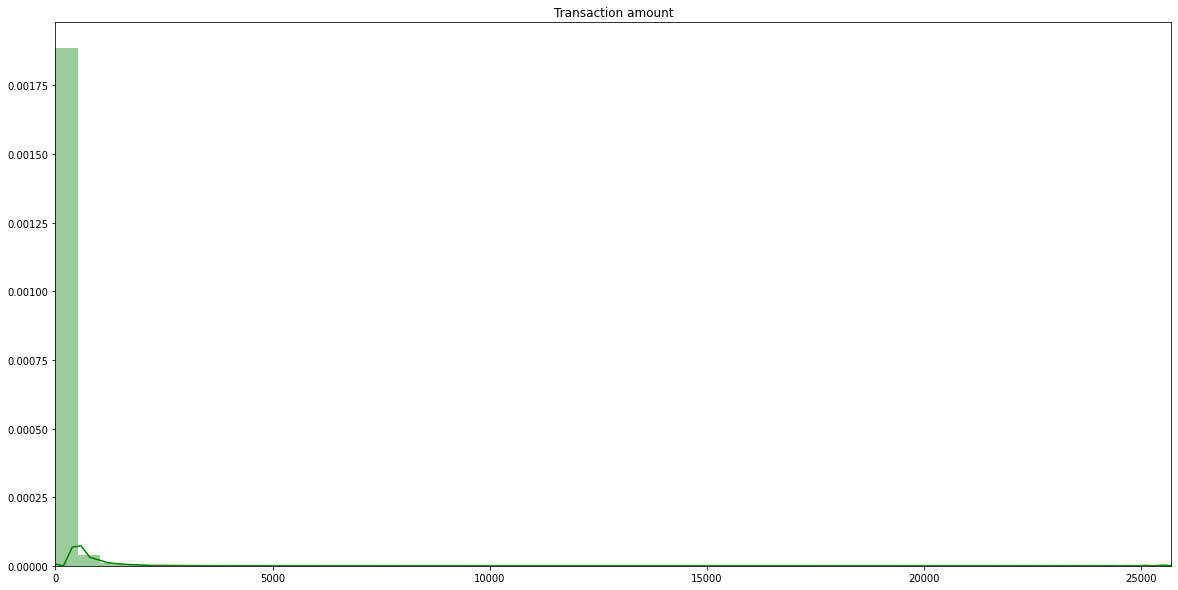

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

amount = data['Amount']

plt.figure(figsize=(20,10))
plt.title('Transaction amount')
plt.xlim((0, amount.max()))

sns.distplot(amount.values, color='g')

The data description told us, that PCA was used before. In order to use PCA, the dataset must be scaled, so we can skip standardization part in data preparation phase. Only time and amount columns are not scaled

### Data preprocessing

With SVM models, it's important to scale the features, otherwise SVM will neglect the smaller feature scales.

### Scaling

Scale amount and time columns with RobustScaler. RobustScaler focuses on the part where the most data is. Because RobustScaler uses interquartile range instead of min and max values, it's robust to outliers than typical normalization. StandardScaler is another option, but it does not work well if the data does not follow Gaussian distribution already.

In [10]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()

data['scaled_time'] = rs.fit_transform(data['Time'].values.reshape(-1, 1))
data['scaled_amount'] = rs.fit_transform(data['Amount'].values.reshape(-1, 1))

data.drop(['Time', 'Amount'], axis=1, inplace=True)


In [11]:
scaled_time = data['scaled_time']
scaled_amount = data['scaled_amount']

data.drop(['scaled_time', 'scaled_amount'], axis=1, inplace=True)
data.insert(0, 'scaled_time', scaled_time)
data.insert(1, 'scaled_amount', scaled_amount)

In [12]:
data.head()

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.994983,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.994983,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-0.994972,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.994972,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.994960,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


#### Rebalancing the data

We need to deal with heavily imbalanced dataset (almost non-existing portion of frauds) so that our model can detect the patterns between fraudulent and non-fraudulent.

Keypoints:
- Train the model with balanced data so the model will detect the patterns
- Test the model with original data to get unbiased results about the performance

#### Undersampling
Remove some data to get balanced (50/50) set of fraudulent and non-fraudulent samples.

We have 492 fraudulent samples which means we reduce non-fraudulent samples down to 492. Notice, that this will cause a massive information loss on the part of non-fraudulent patterns.


In [13]:
# Shuffle data by resampling
data = data.sample(frac=1)
fraudulent = data[data['Class'] == 1]
non_fraudulent = data[data['Class'] == 0][:492]

# Shuffle balanced data again so model does not pick any correlation from the order
balanced_df = pd.concat([fraudulent, non_fraudulent]).sample(frac=1, random_state=42)

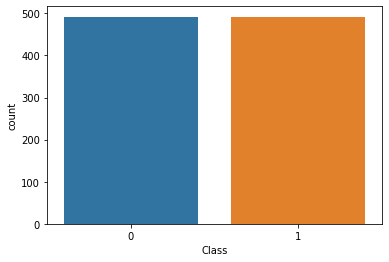

In [14]:
sns.countplot('Class', data=balanced_df)

#### Correlations

Correlation analysis should be done on the subsample to detect highly correlated features.

TODO


#### Outlier removal
TODO

### Model training

We'll use SVC as our main classifier with undersampled data.
The data should be undersampled DURING THE CROSSVALIDATION, otherwise the model most probably overfits and gives us biased results.

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import LinearSVC

X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

clf = LinearSVC()

# Accuracy, no oversampling
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)
scores = cross_val_score(clf, X, y, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [16]:
print("Training score ", round(scores.mean(), 2) * 100, "% accuracy score")

Training score  93.0 % accuracy score


Accuracy for classification is 94%. This means nothing since the data is heavily balanced. Other metrics like precision/recall and ROC should be used as evaluation metric for classification problem.

There's also another problem:
We should nevere undersample before cross validation. If we do that, we will leak data from validation sets to training set and our model evaluation metrics will give us overly optimistic results.

In [17]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(clf, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    fig = plt.figure(figsize=(15,10))
    if ylim is not None:
        plt.ylim(*ylim)
    
    train_sizes, train_scores, test_scores = learning_curve(
        clf, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax = plt.gca()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax.set_xlabel('Training size (m)')
    ax.set_ylabel('Score')
    ax.grid(True)
    ax.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

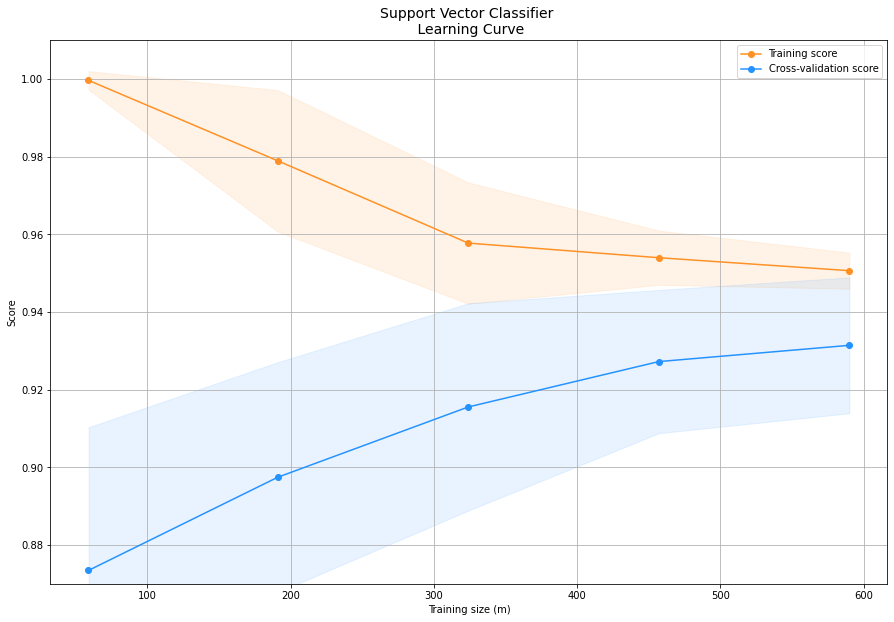

In [18]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

Closing gap means that the model is actually converging to the point where trainin accuracy matches validation accuracy if we give it enough data.

The wider the gap, the more the model is overfitting.

In [19]:
from sklearn.model_selection import cross_val_predict
pred = cross_val_predict(clf, X_train, y_train, cv=5, method='decision_function')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [20]:
from sklearn.metrics import roc_curve
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, pred)

In [21]:
from sklearn.metrics import roc_auc_score
print('Area under curve: ', roc_auc_score(y_train, pred))

Area under curve:  0.9642292795143356


In [22]:
def plot_roc_curve(false_positive_rate, true_positive_rate, pred, y):
  plt.figure(figsize=(16,8))
  plt.title('ROC Curve', fontsize=15)
  plt.plot(false_positive_rate, true_positive_rate, label='Support Vector Classifier score: {:.4f}'.format(roc_auc_score(y, pred)))
  plt.plot([0, 1], [0, 1], 'r-')
  plt.axis([-0.01, 1, 0, 1])
  plt.xlabel('False Positive Rate', fontsize=15)
  plt.ylabel('True Positive Rate', fontsize=15)
  plt.annotate('Minimum ROC score (50%)', xy=(0.5, 0.5), xytext=(0.6, 0.4), arrowprops=dict(facecolor='#FF0000', shrink=0.05))
  plt.legend()
  plt.show()


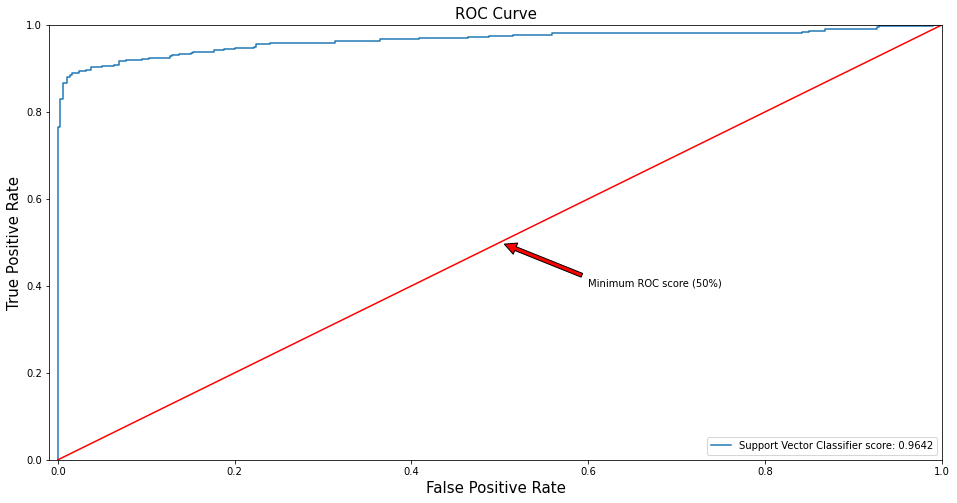

In [23]:
plot_roc_curve(false_positive_rate, true_positive_rate, pred, y_train)

True positives = Correctly classified frauds

False positives = Incorrectly classified non-frauds as frauds

True negatives = Correctly classified non-frauds

False negatives = Incorrectly classified frauds as non-frauds

The goal is to detect as many frauds as possible. In other words, maximize true positives and minimize false negatives. This is same as maximizing recall.

$Recall = \frac{\text{True positives}}{\text{True positives} + \text{False negatives}}$


In [24]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_precision_recall_curve(y_true, y_pred):
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.1])
  plt.xlim([0.0, 1.0])



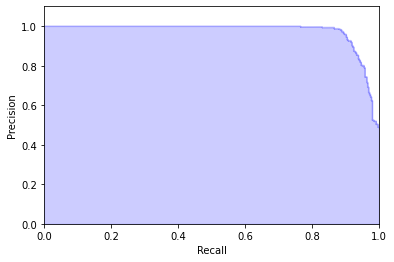

In [25]:
plot_precision_recall_curve(y_train, pred)

### Undersampling during crossvalidation - the right way

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report
#from imblearn.over_sampling import SMOTE

X = data.drop('Class', axis=1)
y = data['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
clf = LinearSVC()

accuracy = []
precision = []
recall = []
f1 = []
auc = []
report = []

undersample_X = X.values
undersample_y = y.values

# Undersample during crossvalidation
for train, test in sss.split(undersample_X, undersample_y):
  undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), clf)
  undersample_model = undersample_pipeline.fit(undersample_X[train], undersample_y[train])
  undersample_prediction = undersample_model.predict(undersample_X[test])

  # Metrics
  accuracy.append(undersample_pipeline.score(undersample_X[test], undersample_y[test]))
  precision.append(precision_score(undersample_y[test], undersample_prediction))
  recall.append(recall_score(undersample_y[test], undersample_prediction))
  f1.append(f1_score(undersample_y[test], undersample_prediction))
  auc.append(roc_auc_score(undersample_y[test], undersample_prediction))


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [27]:
print("Accuracy Score: {:.2f}".format(np.mean(accuracy)))
print("Precision Score: {:.2f}".format(np.mean(precision)))
print("Recall Score: {:.2f}".format(np.mean(recall)))
print("F1 Score: {:.2f}".format(np.mean(f1)))

Accuracy Score: 0.59
Precision Score: 0.00
Recall Score: 0.93
F1 Score: 0.01


The results with correct undersampling are significantly worse but more valid since we did not leak any information from the validation sets to training set.

## Evaluation on the test set

In [28]:
test_pred = clf.predict(X_test)

In [40]:
def report_results(clf, X, y, preds):
  print('Number of normal transactions:', len(y[y == 0]))
  print('Number of frauds:', len(y[y == 1]))
  
  clf_report = classification_report(y, preds)
  print(clf_report)

  plot_precision_recall_curve(y, preds)
  plot_confusion_matrix(clf, X, y)
  plot_roc_curve(clf, X, y)

Number of normal transactions: 113
Number of frauds: 133
              precision    recall  f1-score   support

           0       0.83      0.61      0.70       113
           1       0.73      0.89      0.80       133

    accuracy                           0.76       246
   macro avg       0.78      0.75      0.75       246
weighted avg       0.78      0.76      0.76       246



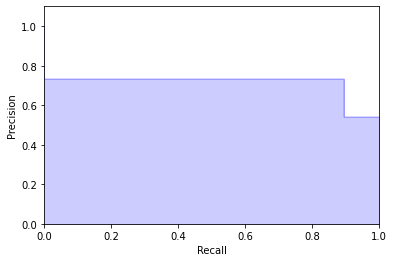

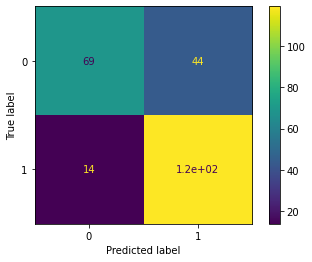

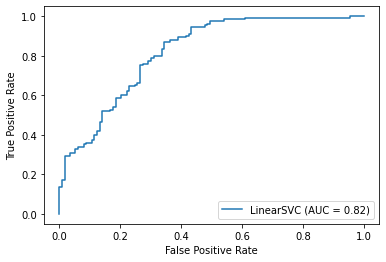

In [41]:
report_results(clf, X_test, y_test, test_pred)